# Feature Selection

Below, I try to see which features are the most predictive of the y-values using feature selection

## Load data

Import packages

In [1]:
import pandas as pd
import numpy as np

Function to load file as a numpy array:

In [2]:
# load a single txt file as a numpy array
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

Function to load a group of variables into a 3D numpy array:

In [3]:
# load a group of files, such as x y and z data for a given variable
def load_group(filenames, directory=''):
    loaded = []
    for name in filenames:
        data = load_file(directory + name)
        loaded.append(data)
    # stack group so that features are in the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

Function to load all inertial signals in a group, train or test, as a 3D numpy array:

In [4]:
# load a dataset group, such as train or test
def load_dataset(group, main_data_dir=''):
    filepath = main_data_dir + group + '/Inertial Signals/'
    # get all 9 files in Inertial Signals into a single filename list
    filenames = []
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output 
    y = load_file(main_data_dir + group + '/y_'+group+'.txt')
    return X, y

Training data raw inertial signals

In [5]:
# load raw training data
raw_train_X, raw_train_y = load_dataset('train', 'UCI HAR Dataset/')
train_sub_map = load_file("UCI HAR Dataset/train/subject_train.txt")

Test data raw inertial signals

In [6]:
# load raw test data
raw_test_X, raw_test_y = load_dataset('test', 'UCI HAR Dataset/')
test_sub_map = load_file("UCI HAR Dataset/test/subject_test.txt")

Concatenate the data so that I can later cross validate it myself

In [7]:
concat_sub_map = np.concatenate((train_sub_map, test_sub_map), axis=None)
concat_X = np.concatenate((raw_train_X, raw_test_X), axis=0)
concat_y = np.concatenate((raw_train_y, raw_test_y), axis=None)
print(concat_sub_map.shape)
print(concat_X.shape)
print(concat_y.shape)

(10299,)
(10299, 128, 9)
(10299,)


Load processed train data

In [8]:
eng_train_X = load_file("UCI HAR Dataset/train/X_train.txt")
eng_train_y = load_file("UCI HAR Dataset/train/y_train.txt")

Load test data and print data shape

In [9]:
eng_test_X = load_file("UCI HAR Dataset/test/X_test.txt")
eng_test_y = load_file("UCI HAR Dataset/test/y_test.txt")

Concatenate the data so that I can later cross validate it myself

In [11]:
eng_concat_X = np.concatenate((eng_train_X, eng_test_X), axis=0)
eng_concat_y = np.concatenate((eng_train_y, eng_test_y), axis=None)
print(concat_sub_map.shape)
print(eng_concat_X.shape)
print(eng_concat_y.shape)

(10299,)
(10299, 561)
(10299,)


## Extract custom features from the data

To improve the classification accuracy of models, I extracted features from the data. Using the advice of Martin et al. (2017) www.mdpi.com/1424-8220/17/9/2058/htm, 
</br>
I selected the following features:
</br>
mean, median, variance, minimum, maximum, interquartile range, 20th percentile and 80th percentile

Extract the features in axis 1 of the dataset, which corresponds to time. The dimensionality of the dataset should be reduced to (10299, 9) in each case.

In [12]:
from scipy.stats import iqr

In [13]:
print(np.mean(concat_X, axis=1).shape)
print(np.median(concat_X, axis=1).shape)
print(np.var(concat_X, axis=1).shape)
print(np.amin(concat_X, axis=1).shape)
print(np.amax(concat_X, axis=1).shape)
print(iqr(concat_X, axis=1).shape)
print(np.percentile(concat_X, 20, axis=1).shape)
print(np.percentile(concat_X, 80, axis=1).shape)

(10299, 9)
(10299, 9)
(10299, 9)
(10299, 9)
(10299, 9)
(10299, 9)
(10299, 9)
(10299, 9)


Concatenate the features to create a new X array. Shape should be (10299, 72).

In [14]:
means = np.mean(concat_X, axis=1)
medians = np.median(concat_X, axis=1)
variances = np.var(concat_X, axis=1)
minimums = np.amin(concat_X, axis=1)
maximums = np.amax(concat_X, axis=1)
IQRs = iqr(concat_X, axis=1)
twenties = np.percentile(concat_X, 20, axis=1)
eighties = np.percentile(concat_X, 80, axis=1)
features_X = np.concatenate((means, medians, variances, minimums, maximums, IQRs, twenties, eighties), 
                            axis=1)

In [15]:
features_X.shape

(10299, 72)

## Variance threshold

Eliminates all features with variance across samples less than the threshold. We find that there are only 8 features out of the 72 with variances greater than 0.2. As you decrease the threshold, more features are included.

Variance thresholding for my feature engineered data.

In [48]:
from sklearn.feature_selection import VarianceThreshold

variances = [0.2, 0.1, 0.05, 0.01]
for x in variances:
    sel = VarianceThreshold(threshold=x)
    sel.fit(features_X)
    # print(sel.variances_)
    X_selected = sel.transform(features_X)
    print("variance", x, X_selected.shape)

variance 0.2 (10299, 8)
variance 0.1 (10299, 25)
variance 0.05 (10299, 34)
variance 0.01 (10299, 49)


Get indexes of features that have greatest variance

In [52]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.2)
sel.fit(features_X)
a = sel.variances_
i = np.where(a>0.2)[0]
i

array([28, 29, 33, 34, 35, 36, 42, 43])

Create array of features in the order that they appear in the array of loaded data

In [61]:
a=['mean','median','variance','min','max','IQR','20','80']
b=['total_acc_x','total_acc_y','total_acc_z','body_acc_x','body_acc_y','body_acc_z',
   'body_gyro_x','body_gyro_y','body_gyro_z',]

comb = np.array([(x,y) for x in a for y in b])
comb.shape

(72, 2)

The features that have the greatest variance are printed out below

In [54]:
comb[i]

array([['min', 'total_acc_y'],
       ['min', 'total_acc_z'],
       ['min', 'body_gyro_x'],
       ['min', 'body_gyro_y'],
       ['min', 'body_gyro_z'],
       ['max', 'total_acc_x'],
       ['max', 'body_gyro_x'],
       ['max', 'body_gyro_y']], dtype='<U11')

Variance thresholding for the pre-engineered data.

In [55]:
variances = [0.2, 0.1, 0.05, 0.01]
for x in variances:
    sel = VarianceThreshold(threshold=x)
    sel.fit(eng_concat_X)
    X_selected = sel.transform(eng_concat_X)
    print("variance", x, X_selected.shape)

variance 0.2 (10299, 55)
variance 0.1 (10299, 183)
variance 0.05 (10299, 364)
variance 0.01 (10299, 521)


Get indexes of features that have greatest variance

In [63]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.2)
sel.fit(eng_concat_X)
a = sel.variances_
i = np.where(a>0.2)[0]

array([  4,   7,   9,  15,  22,  40,  49,  52,  56,  57,  77,  78,  79,
       102, 103, 104, 142, 144, 182, 183, 184, 200, 203, 205, 208, 213,
       216, 218, 221, 234, 247, 260, 266, 269, 271, 272, 280, 287, 288,
       289, 350, 366, 367, 368, 445, 446, 447, 510, 523, 536, 549, 555,
       556, 557, 558])

Load features.txt

In [64]:
eng_features = load_file('UCI HAR Dataset/features.txt')
eng_features.shape

(561, 2)

The features that have the greatest variance are printed out below

In [65]:
eng_features[i]

array([[5, 'tBodyAcc-std()-Y'],
       [8, 'tBodyAcc-mad()-Y'],
       [10, 'tBodyAcc-max()-X'],
       [16, 'tBodyAcc-sma()'],
       [23, 'tBodyAcc-entropy()-X'],
       [41, 'tGravityAcc-mean()-X'],
       [50, 'tGravityAcc-max()-X'],
       [53, 'tGravityAcc-min()-X'],
       [57, 'tGravityAcc-energy()-X'],
       [58, 'tGravityAcc-energy()-Y'],
       [78, 'tGravityAcc-correlation()-X,Y'],
       [79, 'tGravityAcc-correlation()-X,Z'],
       [80, 'tGravityAcc-correlation()-Y,Z'],
       [103, 'tBodyAccJerk-entropy()-X'],
       [104, 'tBodyAccJerk-entropy()-Y'],
       [105, 'tBodyAccJerk-entropy()-Z'],
       [143, 'tBodyGyro-entropy()-X'],
       [145, 'tBodyGyro-entropy()-Z'],
       [183, 'tBodyGyroJerk-entropy()-X'],
       [184, 'tBodyGyroJerk-entropy()-Y'],
       [185, 'tBodyGyroJerk-entropy()-Z'],
       [201, 'tBodyAccMag-mean()'],
       [204, 'tBodyAccMag-max()'],
       [206, 'tBodyAccMag-sma()'],
       [209, 'tBodyAccMag-entropy()'],
       [214, 'tGravityAccMag-mea

The features that I have identified, for both my feature extracted dataset and the pre-engineered dataset, are assumedly the best predictors of the class of activity because they have the greatest variance.

## Recursive feature elimination

Select best features using recursive feature elimination and cross validate with K fold

Tried RFE with random forest classifier because it exposes the `coef_` and `feature_importances_` attributes. Also it handles interactions well and doesn't require careful tuning of parameters

Recursive feature elimination cross validation with my extracted feature data

Number of features corresponding to max CV score : 55


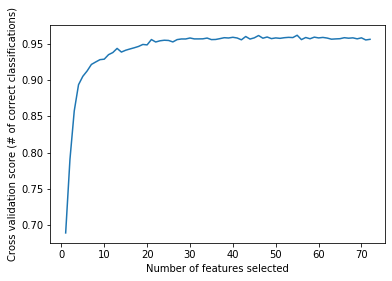

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

# instantiate the random forest classifier and the cross validation object
clf = RandomForestClassifier(n_estimators=10)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the RFE object and compute a cross-validated score.
rfecv = RFECV(estimator=clf,
                        step=1,
                        cv=kf,
                        scoring='accuracy')
rfecv.fit(features_X, concat_y)

print("Number of features corresponding to max CV score : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (# of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

RFECV with the pre-engineered feature data

Number of features corresponding to max CV score : 90


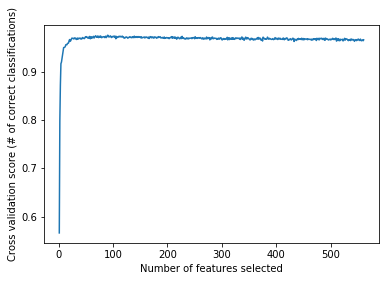

In [67]:
# random forest classifier and cross validation object already instantiated
# RFECV object already instantiated

# fit RFECV to pre-engineered data this time
rfecv.fit(eng_concat_X, eng_concat_y)

print("Number of features corresponding to max CV score : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (# of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

I found that using more features, in both my feature extracted dataset and the pre-engineered dataset, only increased performance of the model up to a certain point. After a while, in fact, it seems that using more features decreases performance of the model due to overfitting.